In [1]:
import torch as t
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt

In [2]:
t.manual_seed(1)    # reproducible

In [3]:
EPOCH=1
BATCH_SIZE=50
LR=0.001
DOWN_MNIST=False

In [4]:
train_data=torchvision.datasets.MNIST(
            root='./mnist',
            train=True,
            transform=torchvision.transforms.ToTensor(),#將下載的資料轉乘torch格式 在for迴圈會將數值轉為為0到1 
            download=DOWN_MNIST
        )

In [5]:
device = t.device('cuda:0') #如果你想用gpu，改成t.device('cuda:0')'cpu'

In [6]:
print('all:',train_data)
print('train_data:',train_data.train_data.shape)
print('train_labels:',train_data.train_labels.shape)

all: Dataset MNIST
    Number of datapoints: 60000
    Root location: ./mnist
    Split: Train
    StandardTransform
Transform: ToTensor()
train_data: torch.Size([60000, 28, 28])
train_labels: torch.Size([60000])


D:\python\envs\two_pthon_deep\lib\site-packages\torchvision\datasets\mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
D:\python\envs\two_pthon_deep\lib\site-packages\torchvision\datasets\mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


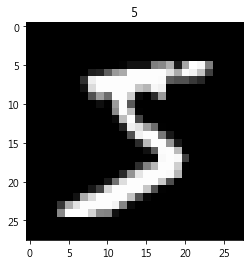

In [7]:
plt.imshow(train_data.train_data[0].numpy(),cmap='gray')
plt.title(train_data.train_labels[0].numpy())
plt.show()

In [8]:
from torch.autograd import Variable as V

In [9]:
train_loader=Data.DataLoader(dataset=train_data,batch_size=BATCH_SIZE,shuffle=True,num_workers=2 )

In [10]:
test_data=torchvision.datasets.MNIST(root='./mnist/',train=False)

In [11]:
test_x=V(t.unsqueeze(test_data.test_data,dim=1),volatile=True).type(t.FloatTensor)[:2000]/255#測試資料要手動轉

D:\python\envs\two_pthon_deep\lib\site-packages\torchvision\datasets\mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
D:\python\envs\two_pthon_deep\lib\site-packages\ipykernel_launcher.py:1: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  """Entry point for launching an IPython kernel.


In [12]:
test_x=test_x

In [13]:
test_y=test_data.test_labels[:2000]

D:\python\envs\two_pthon_deep\lib\site-packages\torchvision\datasets\mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [14]:
#再經過捲積層就會變成相乘
#(1,28,28)
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels=1,out_channels=16,kernel_size=5,stride=1,padding=2),  #(16*28*28)
                        nn.ReLU(),  #(16*28*28)
                        nn.MaxPool2d(kernel_size=2),#(16*14*14)
                    )
            
        self.conv2 = nn.Sequential(
                        nn.Conv2d(16,32,5,1,2),#(32*14*14)
                        nn.ReLU(),#(32*14*14)
                        nn.MaxPool2d(kernel_size=2),#(32*7*7)
                    )
        self.out_layer = nn.Linear(32*7*7,10) #n_input,n_output
        
    
    def forward(self,x): #(1,28,28)
        x = self.conv1(x) #(16*28*28)
        x = self.conv2(x) #(32*7*7) 
        x = x.view(x.size(0),-1)      #展平成1維，確保為1維的數據
        output=self.out_layer(x) #32*7*7,10
        return output 

In [15]:
print(CNN())

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out_layer): Linear(in_features=1568, out_features=10, bias=True)
)


In [16]:
cnn=CNN()

In [17]:
optimizer=t.optim.Adam(cnn.parameters(),lr=LR)#優化器

In [18]:
loss_func=nn.CrossEntropyLoss() #損失函數

In [19]:
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader
        b_x = V(x)   # batch x
        b_y = V(y)   # batch y

        output = cnn(b_x)               # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients

            
        if step % 100 == 0:
            test_output = cnn(test_x)
            pred_y = t.max(test_output, 1)[1]#因為是relu，所以max取機率最高的機率
            accuracy = (pred_y == test_y).sum().item() / float(test_y.size(0))
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.item(), '| test accuracy: %.2f' % accuracy)


Epoch:  0 | train loss: 2.2971 | test accuracy: 0.10
Epoch:  0 | train loss: 0.2032 | test accuracy: 0.90
Epoch:  0 | train loss: 0.1121 | test accuracy: 0.93
Epoch:  0 | train loss: 0.0945 | test accuracy: 0.95
Epoch:  0 | train loss: 0.0621 | test accuracy: 0.96
Epoch:  0 | train loss: 0.1024 | test accuracy: 0.96
Epoch:  0 | train loss: 0.1956 | test accuracy: 0.97
Epoch:  0 | train loss: 0.1306 | test accuracy: 0.97
Epoch:  0 | train loss: 0.1109 | test accuracy: 0.97
Epoch:  0 | train loss: 0.2096 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0231 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0268 | test accuracy: 0.97


In [23]:
y_0_9_chance=cnn(test_x[:20])
y_pred=t.max(y_0_9_chance,1)[1].data.numpy().squeeze()

In [24]:
print('實際:',test_y[:20].numpy())
print('預測:',y_pred)

實際: [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]
預測: [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]


In [ ]:
32*7*7

In [30]:
1568/28

56.0